In [1]:
import torch
import src.data_processing as dp
from src.configs import DatasetConfig, AEConfig, EMConfig
import src.analysis as analysis
from src.train import load_objects
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import pandas as pd
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


species_of_interest = ["H", "HE", "H2", "O", "C", "N", "SPlus", "MG", "SIPlus", "CL", "CPlus", "SURFACE", "BULK", "AtCO", "AtH", "E_minus"]

In [ ]:
validation_t, validation_indices = dp.load_tensors_from_hdf5(category="validation") # This has columns [metadata, physical_parameters, species, encoded_species]

#np.random.shuffle(validation_indices)

tensors = (validation_t, validation_indices)

validation_indices = validation_indices[:10000]

test = validation_indices[validation_indices[:, 2] == 53]

print(len(test))

#dp.save_tensors_to_hdf5(tensors, category="validation")

tensor([[0.2480, 0.4791, 0.6052,  ..., 0.0000, 0.0000, 0.0000],
        [0.2480, 0.4791, 0.6052,  ..., 0.2389, 0.0000, 0.0000],
        [0.2480, 0.4791, 0.6052,  ..., 0.2473, 0.1834, 0.1308],
        ...,
        [0.2882, 0.1191, 0.4987,  ..., 0.6767, 0.4591, 0.0000],
        [0.2882, 0.1191, 0.4987,  ..., 0.6769, 0.4593, 0.0000],
        [0.2882, 0.1191, 0.4987,  ..., 0.6770, 0.4594, 0.0000]])
87


### This section is for obtaining the error plots across species and timesteps.

In [ ]:

emulator, autoencoder, _, _ = load_objects(is_inference=True)

validation_t, validation_indices = dp.load_tensors_from_hdf5(category="validation") # This has columns [metadata, physical_parameters, species, encoded_species]

validation_indices = validation_indices[1000000:1010000]

validation_Dataset = dp.RowRetrievalDataset(validation_t, validation_indices)

validation_dataloader = dp.tensor_to_dataloader(EMConfig, validation_Dataset, is_emulator=True)

num_timesteps = 100
num_species = DatasetConfig.num_species

total_rel_error = torch.zeros(num_timesteps, num_species, dtype=torch.float32)
total_count = torch.zeros(num_timesteps, dtype=torch.float32)

with torch.no_grad():
    for features, targets in validation_dataloader:        
        targets = targets.to(device)
        emulated_features = dp.emulator_inferencing(emulator, features)
        decoded_features = dp.decoder_inferencing(autoencoder, emulated_features)
        
        unscaled_targets = dp.inverse_abundances_scaling(targets)
        
        rel_error = (torch.abs(unscaled_targets - decoded_features) / unscaled_targets)
        
        timesteps = (features[:, 0]*100).round().int()
        
        batch_size = rel_error.size(0)
        for i in range(batch_size):
            t = timesteps[i].cpu() - 1
            total_rel_error[t] += rel_error[i].cpu()
            total_count[t] += 1

mean_rel_error_timestep_species = torch.zeros_like(total_rel_error)
mean_rel_error_timestep_species = (
    total_rel_error / total_count.unsqueeze(1)
)
mean_rel_error_across_species = mean_rel_error_timestep_species.mean(dim=1)
std_rel_error_timestep = mean_rel_error_timestep_species.std(dim=1)



Loading Pretrained Model
tensor([[5556474, 5556505,      31],
        [3877303, 3877350,      47],
        [3105265, 3105329,      64],
        ...,
        [3867208, 3867274,      66],
        [4810289, 4810321,      32],
        [4989416, 4989495,      79]], dtype=torch.int32)
Data_matrix Memory usage: 8181.123 MB
Index_pairs Memory usage: 0.11 MB

Dataset Size: 6058283 | Index Pairs: 10000

tensor([[4.1300e-01, 2.9293e-01, 2.8771e-01,  ..., 2.3553e-01, 2.5070e-01,
         1.4015e-01],
        [7.6441e-01, 3.1275e-01, 3.2930e-01,  ..., 2.6592e-01, 3.1047e-01,
         1.6260e-01],
        [4.9277e-01, 2.5391e-01, 3.7257e-01,  ..., 2.1299e-01, 2.5240e-01,
         1.2112e-01],
        ...,
        [3.6667e-01, 3.1548e-01, 1.8679e-01,  ..., 2.7423e-01, 8.1293e-01,
         1.4860e-01],
        [1.9251e+00, 9.3710e-01, 4.2854e-01,  ..., 2.4229e-01, 7.0013e-02,
         2.7218e-01],
        [1.7523e+00, 4.9599e-05, 3.8128e-05,  ..., 4.1414e+00, 2.6516e-02,
         5.9081e-01]])


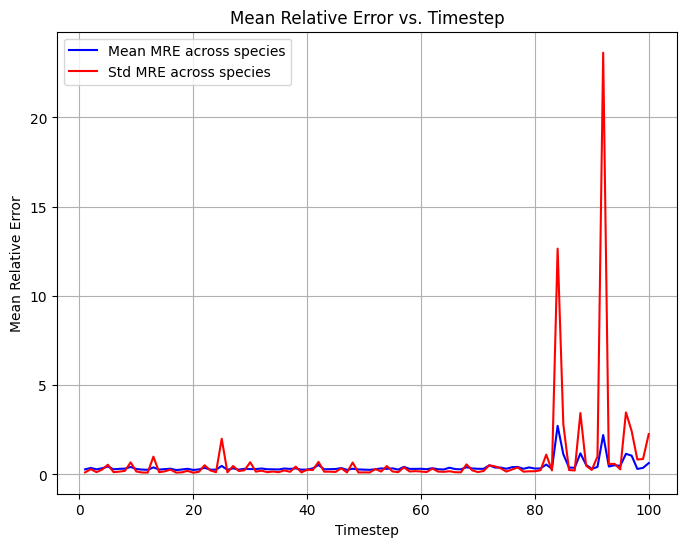

In [ ]:
mean_error = mean_rel_error_across_species.cpu().numpy()
std_error = std_rel_error_timestep.cpu().numpy()
timesteps = np.arange(num_timesteps)

plt.figure(figsize=(8, 6))
plt.plot(timesteps+1, mean_error, label='Mean MRE across species', color='b')
plt.plot(timesteps+1, std_error, label='Std MRE across species', color='r')

plt.xlabel('Timestep')
plt.ylabel('Mean Relative Error')
plt.title('Mean Relative Error vs. Timestep')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
timestep = 95

training_t, _ = dp.load_tensors_from_hdf5(category="training") # This has columns [metadata, physical_parameters, species, encoded_species]
filtered_t = training_t[training_t[:, 2] == timestep*1000][:, DatasetConfig.num_metadata:-AEConfig.latent_dim]
del training_t
filtered_t[:, :DatasetConfig.num_physical_parameters] = dp.inverse_physical_parameter_scaling(filtered_t[:, :DatasetConfig.num_physical_parameters])
filtered_t[:, DatasetConfig.num_physical_parameters:] = dp.inverse_abundances_scaling_cpu(filtered_t[:, DatasetConfig.num_physical_parameters:])

In [ ]:
training_df = pd.DataFrame(filtered_t.numpy(), columns=DatasetConfig.physical_parameters + DatasetConfig.species)

output_folder = "plots/actual_abundances_vs_physical_parameters"
analysis.scatter_abundances_vs_physical_parameters(
    df = training_df,
    species_of_interest = species_of_interest,
    output_folder = output_folder
    )

In [ ]:
num_samples = 100000
initial_conditions = analysis.sample_initial_conditions(num_samples)
initial_conditions_with_time = analysis.add_timesteps_to_conditions(initial_conditions, timestep)

emulator, autoencoder, _, _ = load_objects()

with torch.no_grad():
    encoded_features = dp.encoder_inferencing(autoencoder, initial_conditions_with_time)
    
    encoded_features = dp.emulator_inferencing(emulator, encoded_features)
    
    decoded_features = dp.decoder_inferencing(autoencoder, encoded_features)

results_df = analysis.reconstruct_results(initial_conditions_with_time, decoded_features)

In [ ]:
output_folder = "plots/predicted_abundances_vs_physical_parameters"
analysis.scatter_abundances_vs_physical_parameters(
    df = results_df,
    species_of_interest = species_of_interest,
    output_folder = output_folder
    )